In [1]:
import sys

sys.path.append('../../../code/')
import os
import json
from datetime import datetime
import time
from math import *

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats

import igraph as ig

from load_data import load_citation_network, case_info

%load_ext autoreload
%autoreload 2
%matplotlib inline

data_dir = '../../data/'
court_name = 'scotus'

# load into igraph

In [2]:
start = time.time()
if court_name == 'all':
    case_metadata = pd.read_csv(data_dir + 'clean/case_metadata_master.csv')

    edgelist = pd.read_csv(data_dir + 'clean/edgelist_master.csv')
else:
    net_dir = data_dir + 'clean/' + court_name + '/'
    if not os.path.exists(net_dir):
        os.makedirs(net_dir)
        make_court_subnetwork(court_name, data_dir)

    case_metadata = pd.read_csv(net_dir + 'case_metadata.csv')

    edgelist = pd.read_csv(net_dir + 'edgelist.csv')
    edgelist.drop('Unnamed: 0', inplace=True, axis=1)

# create a dictonary that maps court listener ids to igraph ids
cl_to_ig_id = {}
cl_ids = case_metadata['id'].tolist()
for i in range(case_metadata['id'].size):
    cl_to_ig_id[cl_ids[i]] = i

# add nodes
V = case_metadata.shape[0]
g = ig.Graph(n=V, directed=True)
# g.vs['date'] = case_metadata['date'].tolist()
g.vs['name'] = case_metadata['id'].tolist()

# create igraph edgelist
cases_w_metadata = set(cl_to_ig_id.keys())
ig_edgelist = []
missing_cases = 0
start = time.time()
for row in edgelist.itertuples():

    cl_ing = row[1]
    cl_ed = row[2]

    if (cl_ing in cases_w_metadata) and (cl_ed in cases_w_metadata):
        ing = cl_to_ig_id[cl_ing]
        ed = cl_to_ig_id[cl_ed]
    else:
        missing_cases += 0
    
    ig_edgelist.append((ing, ed))

# add edges to graph
g.add_edges(ig_edgelist)

# add vertex attributes
g.vs['court'] =  case_metadata['court'].tolist()
g.vs['year'] = [int(d.split('-')[0]) for d in case_metadata['date'].tolist()]

end = time.time()

print '%d seconds for %d edges' % (end - start, len(g.es))

0 seconds for 250465 edges


# compute the edge ages

In [3]:
citation_ages = []
source_ages = []
for e in g.es:
    source = g.vs[e.source]
    target = g.vs[e.target]
    
    source_year = source['year']
    target_year = target['year']
    
    edge_age = source_year - target_year
    if edge_age > 0:
        citation_ages.append(edge_age) 
        source_ages.append(source_year)

# citation age histogram

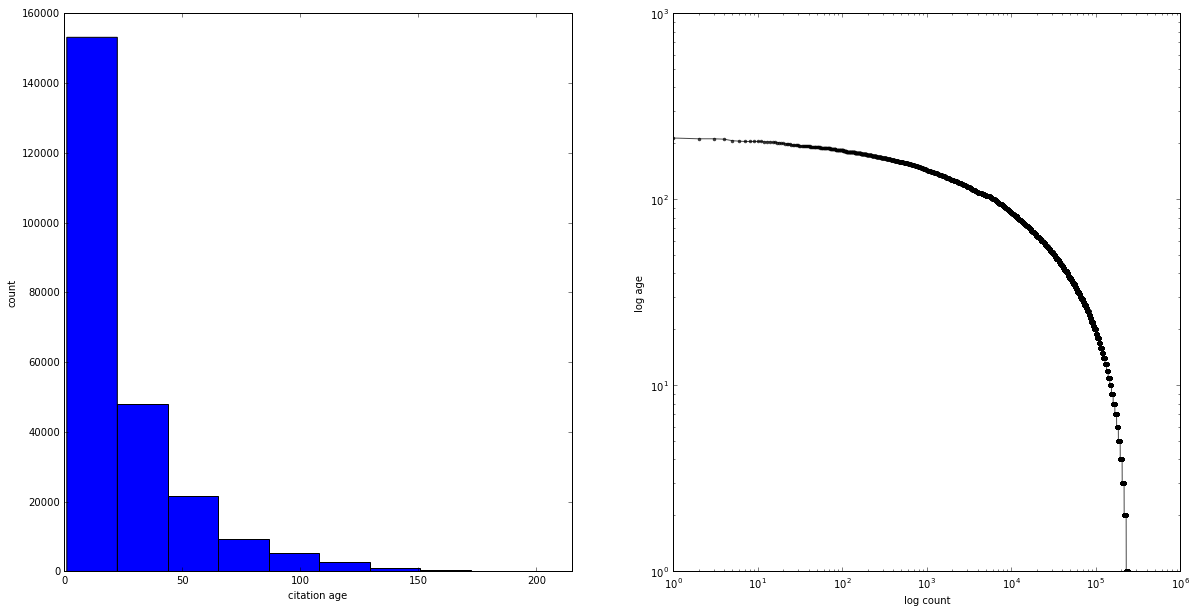

In [4]:
plt.figure(figsize=[20, 10])

plt.subplot(1,2,1)
plt.hist(citation_ages);
plt.xlim([0, max(citation_ages)])
plt.xlabel('citation age')
plt.ylabel('count')


plt.subplot(1,2,2)
plt.loglog(sorted(citation_ages, reverse=True), '-', marker='.', color='black',
           alpha=.7);
plt.ylabel('log age')
plt.xlabel('log count')

# source age vs. citation age

(0, 215)

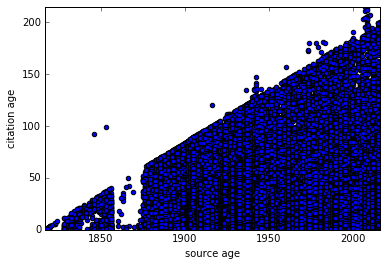

In [5]:
plt.scatter(source_ages, citation_ages)
plt.xlabel('source age')
plt.ylabel('citation age')
plt.xlim([min(source_ages), max(source_ages)])
plt.ylim([0, max(citation_ages)])

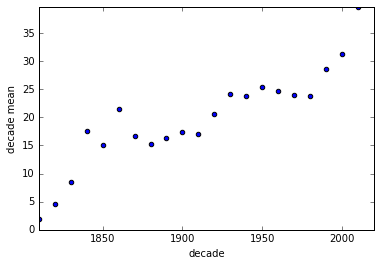

In [19]:
bins = range(1810, 2020 + 1, 10)
bin_means = stats.binned_statistic(source_ages, citation_ages, statistic='mean', bins=bins).statistic
plt.scatter(bins[:-1], bin_means)
plt.xlim([min(bins), max(bins)])
plt.ylim([0, max(bin_means)])
plt.xlabel('decade')
plt.ylabel('decade mean')

# time vs. indegree

(1754, 2016)

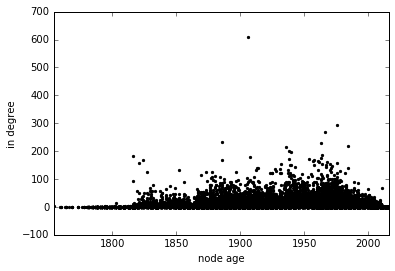

In [6]:
indegrees = g.indegree()
plt.scatter(g.vs['year'], indegrees,
            marker='.',
            color='black')
plt.xlabel('node age')
plt.ylabel('in degree')

plt.xlim([min(g.vs['year']), max(g.vs['year'])])
# plt.ylim([0, 200])